## Load necessary modules

In [1]:
from PIL import Image

#import xml.etree.ElementTree as ET
from lxml import etree as ET

# show images inline
%matplotlib inline

# automatically reload modules when they have changed
%load_ext autoreload
%autoreload 2

# import keras
import keras

# import keras_retinanet
from keras_retinanet import models
from keras_retinanet.utils.image import read_image_bgr, preprocess_image, resize_image
from keras_retinanet.utils.visualization import draw_box, draw_caption
from keras_retinanet.utils.colors import label_color

# import miscellaneous modules
import matplotlib.pyplot as plt
import cv2
import os
import numpy as np
import time

# set tf backend to allow memory to grow, instead of claiming everything
import tensorflow as tf

def get_session():
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    return tf.Session(config=config)

# use this environment flag to change which GPU to use
#os.environ["CUDA_VISIBLE_DEVICES"] = "1"

# set the modified tf session as backend in keras
keras.backend.tensorflow_backend.set_session(get_session())

Using TensorFlow backend.


## Load RetinaNet model

In [2]:
# adjust this to point to your downloaded/trained model
# models can be downloaded here: https://github.com/fizyr/keras-retinanet/releases
model_path = os.path.join('./', 'snapshots', 'resnet50_coco_best_v2.1.0.h5')

# load retinanet model
model = models.load_model(model_path, backbone_name='resnet50')

# if the model is not converted to an inference model, use the line below
# see: https://github.com/fizyr/keras-retinanet#converting-a-training-model-to-inference-model
#model = models.convert_model(model)

#print(model.summary())

# load label to names mapping for visualization purposes
labels_to_names = {0: 'person', 1: 'bicycle', 2: 'car', 3: 'motorcycle', 4: 'airplane', 5: 'bus', 6: 'train', 7: 'truck', 8: 'boat', 9: 'traffic light', 10: 'fire hydrant', 11: 'stop sign', 12: 'parking meter', 13: 'bench', 14: 'bird', 15: 'cat', 16: 'dog', 17: 'horse', 18: 'sheep', 19: 'cow', 20: 'elephant', 21: 'bear', 22: 'zebra', 23: 'giraffe', 24: 'backpack', 25: 'umbrella', 26: 'handbag', 27: 'tie', 28: 'suitcase', 29: 'frisbee', 30: 'skis', 31: 'snowboard', 32: 'sports ball', 33: 'kite', 34: 'baseball bat', 35: 'baseball glove', 36: 'skateboard', 37: 'surfboard', 38: 'tennis racket', 39: 'bottle', 40: 'wine glass', 41: 'cup', 42: 'fork', 43: 'knife', 44: 'spoon', 45: 'bowl', 46: 'banana', 47: 'apple', 48: 'sandwich', 49: 'orange', 50: 'broccoli', 51: 'carrot', 52: 'hot dog', 53: 'pizza', 54: 'donut', 55: 'cake', 56: 'chair', 57: 'couch', 58: 'potted plant', 59: 'bed', 60: 'dining table', 61: 'toilet', 62: 'tv', 63: 'laptop', 64: 'mouse', 65: 'remote', 66: 'keyboard', 67: 'cell phone', 68: 'microwave', 69: 'oven', 70: 'toaster', 71: 'sink', 72: 'refrigerator', 73: 'book', 74: 'clock', 75: 'vase', 76: 'scissors', 77: 'teddy bear', 78: 'hair drier', 79: 'toothbrush'}

/home/cosmin/.local/lib/python3.6/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


## Run detection on example

In [ ]:
# load image
image = read_image_bgr('./test2/dunseverick/frame01403.jpg')

# copy to draw on
draw = image.copy()
draw = cv2.cvtColor(draw, cv2.COLOR_BGR2RGB)

# preprocess image for network
image = preprocess_image(image)
image, scale = resize_image(image)

# process image
start = time.time()
boxes, scores, labels = model.predict_on_batch(np.expand_dims(image, axis=0))
print("processing time: ", time.time() - start)

# correct for image scale
boxes /= scale

print(scale)

labeled_boxes = []

# visualize detections
for box, score, label in zip(boxes[0], scores[0], labels[0]):
    # scores are sorted so we can break
    if score < 0:
        break
    color = label_color(label)  
    b = box.astype(int)
    draw_box(draw, b, color=color)
    
    caption = "{} {:.3f}".format(labels_to_names[label], score)
    draw_caption(draw, b, caption)
    
    #append box to list of boxes for IoU processing and assignment
    labeled_boxes.append(box)
    print(labels_to_names[label], score)
'''
label = 0;
score = 1
color = label_color(label) 
b = bb
print(b)

  
b[0] += 320
b[1] += 480
b[2] += 320
b[3] += 480

print(b)
draw_box(draw, b, color=color)

caption = "{} {:.3f}".format(labels_to_names[label], score)
draw_caption(draw, b, caption)
'''

plt.figure(figsize=(15, 15))
plt.axis('off')
plt.imshow(draw)
plt.show()

## Function declarations

In [2]:
#given a box in format (x1,y1,x2,y2) returns its area
def Area(box):
    (x1, y1, x2, y2) = box
    return (x2 - x1) * (y2 - y1)

#boxA and boxB in format:(x1,y1,x2,y2)
#returns the Intersection over Union of the 2 boxes
#defined as the intersection area divided by the total(union)
def IoU(boxA, boxB):
    (Ax1, Ay1, Ax2, Ay2) = boxA
    (Bx1, By1, Bx2, By2) = boxB
    
    #compute intersection coordinates
    Ix1 = max(Ax1, Bx1)
    Iy1 = max(Ay1, By1)
    Ix2 = min(Ax2, Bx2)
    Iy2 = min(Ay2, By2)
    
    #if (Ix1, Iy1) does not define the lower left corner of the rectangle
    #the intersection is 0 so IoU is 0 as well
    if Ix1 > Ix2 or Iy1 > Iy2:
        return 0
    
    #computer intersection area
    AreaI = Area((Ix1, Iy1, Ix2, Iy2))
    
    #union can pe computed as Area(A) + Area(B) - Intersection
    AreaA = Area(boxA)
    AreaB = Area(boxB)
    
    AreaU = AreaA + AreaB - AreaI
    
    return AreaI / float(AreaU)

#same as IoU, but divides by area of boxA
def IoF(boxA, boxB):
    (Ax1, Ay1, Ax2, Ay2) = boxA
    (Bx1, By1, Bx2, By2) = boxB
    
    #compute intersection coordinates
    Ix1 = max(Ax1, Bx1)
    Iy1 = max(Ay1, By1)
    Ix2 = min(Ax2, Bx2)
    Iy2 = min(Ay2, By2)
    
    #if (Ix1, Iy1) does not define the lower left corner of the rectangle
    #the intersection is 0 so IoU is 0 as well
    if Ix1 > Ix2 or Iy1 > Iy2:
        return 0
    
    #computer intersection area
    AreaI = Area((Ix1, Iy1, Ix2, Iy2))
    
    #union can pe computed as Area(A) + Area(B) - Intersection
    AreaA = Area(boxA)
    
    return AreaI / float(AreaA)

def IoU_example():
    boxA = (0, 0, 1, 1)
    boxB = (0.5, 0.5, 3, 2)
    iou = IoU(boxA, boxB)
    print('IoU of figures ', boxA, ' and ', boxB, ' is: ', iou)

IoU_example()
#TODO: something that assigns box pairs in the best way to compute error properly

IoU of figures  (0, 0, 1, 1)  and  (0.5, 0.5, 3, 2)  is:  0.05555555555555555


## Functions for getting file names/renaming images

In [3]:
#returns a string of the concatenated file prefix, number and format
#the normal is formatted with 5 zeroes, e.g. 00001, 00333, etc
def get_file_name(file_name_prefix, file_number, file_format):
    return file_name_prefix + "{:05d}".format(file_number) + file_format

#same as above, bit without the file format
def get_file_name_no_format(file_name_prefix, file_number):
    return file_name_prefix + "{:05d}".format(file_number)

#renames a set of images of the above format, e.g.
#image_prefix + img_number + img_format
#by adding a fixed number to all of the img_numbers
def rename_images(img_path, img_name_prefix, img_format, first_img_number, last_img_number, add_to_img_number):
    for img_number in range(last_img_number, first_img_number, -1):
        print(img_number)
        old_img_name = get_file_name(img_name_prefix, img_number, img_format)
        new_img_name = get_file_name(img_name_prefix, img_number + add_to_img_number, img_format)
        new_img = os.path.join('./', img_path, new_img_name)
        old_img = os.path.join('./', img_path, old_img_name)
        print('renaming', old_img, 'to', new_img)
        os.rename(old_img, new_img)
        image_path = os.path.join('./', img_path, img_name)

#ATTENTION: Only call such a method only once for each frame set!
#renames all the frames in the first dunseverick set
#this is done to satisfy naming of test frames
def rename_dunseverick_1():
    img_path = 'test2/dunseverick'
    img_name_prefix = 'frame'
    img_format = '.jpg'
    first_image_number = 0 #it is actually 1, but we are passing 0 due to how the in range() construct works
    last_image_number = 2929
    add_to_image_number = 587
       
    rename_images(img_path, img_name_prefix, img_format, first_image_number, last_image_number, add_to_image_number)

## Functions for processing and classifying images

In [4]:
#saves the classified (and annotated) image into the path
#determined by classified_path and img_name
#the image is held into matplotlib.pyplot
#remove the image from pyplot after saving
def save_image(classified_path, img_name):
    #check if file already exists?
    #os.path.isfile(fpath)
    fig = plt.gcf()
    classified_image_path = os.path.join('./', classified_path, img_name)
    dpi = fig.dpi
    plt.savefig(classified_image_path, dpi = dpi);
    plt.close(fig)

#given the image path and name, process and classify the objects in the image with keras retinanet
#detected objects are only considered for further processing if the confidence score exceeds the threshold
#image is held into pyplot, and will be removed after saving
def process_image(img_path, img_name, score_threshold = 0):
    # load image
    image_path = os.path.join('./', img_path, img_name)
    image = read_image_bgr(image_path)
    # copy to draw on
    draw = image.copy()
    draw = cv2.cvtColor(draw, cv2.COLOR_BGR2RGB)

    # preprocess image for network
    image = preprocess_image(image)
    image, scale = resize_image(image)

    # process image
    start = time.time()
    boxes, scores, labels = model.predict_on_batch(np.expand_dims(image, axis=0))
    print("processing image: ", img_name)
    print("processing time: ", time.time() - start)

    # correct for image scale
    boxes /= scale

    labeled_boxes = {}
    #print(boxes.shape)
    # visualize detections
    for box, score, label in zip(boxes[0], scores[0], labels[0]):
        # scores are sorted so we can break
        print(box,score,label)
        if score < score_threshold:
            break
        color = label_color(label)  
        b = box.astype(int)
        draw_box(draw, b, color=color)

        caption = "{} {:.3f}".format(labels_to_names[label], score)
        draw_caption(draw, b, caption)

        #append box to dictionary, transform label into named label
        #create list if not existent
        label = labels_to_names[label]
        if label not in labeled_boxes:
            labeled_boxes[label] = []
            
        labeled_boxes[label].append(box)

    plt.figure(figsize=(15, 15))
    plt.axis('off')
    plt.imshow(draw)
    
    # uncomment next line if you want so visualize the images in the notebook
    #plt.show()
    return labeled_boxes

#img_path - path to the images folder
#img_name_prefix - e.g. frame for frame 00001, etc
#processes all images with the provided path, prefix and format, within the number ranges
#save the results, and return a dictionary with the detections
#frame_name -> {object_class -> [detection1, detection2]} detectioni = (x1, y1, x2, y2)
def process_images(img_path, classified_path, img_name_prefix, first_image_number, last_image_number, img_format):
    labeled_images = {}
    score_threshold = 0.05 # change according to picture type?
    for image_number in range(first_image_number, last_image_number + 1):
        img_name  = get_file_name(img_name_prefix, image_number, img_format)
        img_name_no_format = get_file_name_no_format(img_name_prefix, image_number)
        labeled_image = process_image(img_path, img_name, score_threshold)
        labeled_images[img_name_no_format] = labeled_image
        save_image(classified_path, img_name)
    return labeled_images

## Functions for saving to xml

In [5]:
#key: String
#values: array: values[0] has type, values[1] has array of boxes for class type
#element created has form:
#<annotations>
#<file>key</file>
#<object>
# <name> object_type </name
# <bndbox>
#  <xmin>value</xmin>
#  <xmin>value</ymin>
#  <xmin>value</xmax>
#  <xmin>value</ymax>
#ending labels
#<object>
#.....
def save_to_xml(labeled_boxes, key, path_folder):
    values = labeled_boxes[key]
    #print(values)
    root = ET.Element('annotations')
    elem = ET.SubElement(root, 'file')
    elem.text = key
    for value in values.items():  
        #object type in value[0]
        #array of bounding boxes
        boxes = value[1]
        #iterate through each bounding box
        for box_elems in boxes:
            obj_elem = ET.SubElement(root, 'object')
            type_elem = ET.SubElement(obj_elem, 'name')
            #object type in value[0]
            type_elem.text = value[0]
            print(box_elems)
            
            bndbox_elem = ET.SubElement(obj_elem, 'bndbox')
            #array of element types, to match the annotation style
            elem_types = ['xmin', 'ymin', 'xmax', 'ymax']
            #iterate through all the coordinates in the bounding box
            for index, box_elem in enumerate(box_elems):
                #convert so we can serialise
                box_elem_str = str(box_elem)
                coord_elem = ET.SubElement(bndbox_elem, elem_types[index])
                coord_elem.text = box_elem_str
                
    write_to_xml(root, key, path_folder)

#create xml file at path_folder + key +'.xml'
#using the xml object 'elem'
def write_to_xml(elem, key, path_folder):
    path = path_folder + key + '.xml'
    tree = ET.ElementTree(elem)
    tree.write(path, pretty_print=True)
    print(path)
    
# img_path - path to the images folder
# img_name_prefix - e.g. frame for frame 00001, etc
def save_classifications_to_xml(labeled_boxes, path_folder, img_name_prefix, first_image_number, last_image_number):
    for image_number in range(first_image_number, last_image_number + 1):
        img_name_no_format = get_file_name_no_format(img_name_prefix, image_number)
        save_to_xml(labeled_boxes, img_name_no_format, path_folder)

## Functions for extracting annotations from xml

In [6]:
def extract_text(elem, text):
    return elem.find(text).text

def extract_bndbox(box_elem):
    x1 = extract_text(box_elem, 'xmin')
    y1 = extract_text(box_elem, 'ymin')
    x2 = extract_text(box_elem, 'xmax')
    y2 = extract_text(box_elem, 'ymax')
    
    x1 = float(x1)
    y1 = float(y1)
    x2 = float(x2)
    y2 = float(y2)
    return [x1, y1, x2, y2]

def extract_objects(object_dict, tree_root):
    objects = tree_root.findall('object')
    
    for obj in objects:
        obj_type = extract_text(obj, 'name')
        if obj_type not in object_dict:
            object_dict[obj_type] = []
        
        box_elem = obj.find('bndbox')
        bndbox = extract_bndbox(box_elem)
        object_dict[obj_type].append(bndbox) 
        
    return object_dict
        
#returns list of (file_name, file_path)
def get_all_files(folder_path, file_prefix, file_format, file_number, suffixes):
    files = []
    
    file_prefix_path = folder_path + file_prefix
    for suffix in suffixes:
        file_format_with_suffix = suffix + file_format
        file_name = get_file_name(file_prefix, file_number, file_format_with_suffix)
        file_path = folder_path + file_name
        if not os.path.isfile(file_path):
            continue
        files.append( (file_name, file_path) )
    
    return files

#given an object dictionary with bounding boxes 'object_class' -> (x1. y1. x2. y2)
#file path is the full relative path e.g. './etc/etc/file.xml'
def extract_objects_from_file(file_path, object_dict):
    tree = ET.parse(file_path)
    root = tree.getroot()
    
    object_dict = extract_objects(object_dict, root)
    
    return object_dict

#folder_path is the path to the folder we are extracting data from
#file_prefix is the prefix shared by all files, e.g. file0001,file0002, etc
#file numbers describe which range of files to extract from
#suffixes is an array which describes (possibly) existing suffixes in the files
#suffixes has at least one element, ['']
#e.g. frame001, frame001_a, etc
def extract_objects_from_files(folder_path, file_prefix, file_format, 
                               first_file_number, last_file_number, 
                               suffixes = ['', '_a', '_b', '_c']):
    
    #this is the final dictionary 'file_path' -> labeled_boxes
    labeled_boxes = {}
    
    for file_number in range(first_file_number, last_file_number + 1):
        files = get_all_files(folder_path, file_prefix, file_format, file_number, suffixes)
        object_dict = {}
        for (file_name, file_path) in files:
            object_dict = extract_objects_from_file(file_path, object_dict)
        
        file_name_no_format = get_file_name_no_format(file_prefix, file_number)
        labeled_boxes[file_name_no_format] = object_dict
        
    return labeled_boxes
            

## Functions for pre processing dictionary of boxes

In [7]:
#converts dictionary of boxes to array of boxes
def to_array(labeled_boxes):
    boxes_arr = []
    for class_name, boxes in labeled_boxes.items():
        #iterate over the boxes and add them to array   
        #added element is of form (box, class_name)
        for box in boxes:
            boxes_arr.append((box, class_name))
    
    return boxes_arr
#test data is "centered" on the middle of the frame
#we revert it to the original form, for tests and plotting
#by default, assume centered on middle
def denormalize_boxes(boxes, width = 640, height= 480):
    for box in boxes:
        print(box[0][0])
        box[0][0] += width
        box[0][2] += width
        box[0][1] += height
        box[0][3] += height
    
    return boxes

## Functions for computing accuracy/recall metrics

In [8]:
#given the dictionary of a frame's detections, returns the total number of objects in the frame
def get_frame_nb_objects(key, labeled_boxes):
    boxes = labeled_boxes[key]
    boxes_arr = to_array(boxes)
    
    return len(boxes_arr)

def get_nb_objects(labeled_boxes):
    nb_objects = []
    for key in labeled_boxes:
        frame_objects = get_frame_nb_objects(key, labeled_boxes)
        nb_objects.append(frame_objects)
        
    return nb_objects

def plot_nb_objects(test_nb_objects, classified_nb_objects, title):
    plt.figure()
    plt.title(title)    
    plt.plot(classified_nb_objects, 'r', alpha = 0.3, label = 'Number of detected objects') 
    plt.plot(test_nb_objects, 'y', label = 'Number of classified objects')
    plt.legend(loc='best')

def plot_nb_objects_diff(test_nb_objects, classified_nb_objects, segmented_nb_objects):
    plt.figure()
    plt.title('Detected objects comparison')    
    plt.plot(classified_nb_objects, 'r', alpha = 0.3, label = 'Number of detected objects') 
    plt.plot(segmented_nb_objects, 'b', alpha = 0.1, label = 'Number of segmented objects')
    plt.plot(test_nb_objects, 'y', label = 'Number of classified objects')
    plt.legend(loc='best')    

## Functions for computing IoU metrics

In [20]:
#given a key describing a classified frame, such as frame00555
#and a list of test(truth) and classified boxes
#computes the best matching IoUs greedily and returns an array of them
#IoU is the function we use for the IoU metric
def compute_frame_IoU(key, labeled_test_boxes, labeled_classified_boxes, IoU, normalize):
    test_boxes = labeled_test_boxes[key]
    classified_boxes = labeled_classified_boxes[key]
    
    test_boxes_arr = to_array(test_boxes)
    classified_boxes_arr = to_array(classified_boxes)
    
    #test boxes are centered on the middle of the frame
    #we need to 'de-center' them for plotting/testing
    if normalize:
        test_boxes_arr = denormalize_boxes(test_boxes_arr)
    current_IoUs = []
    
    for test_box in test_boxes_arr:
        max_IoU = 0
        for classified_box in classified_boxes_arr:
            iou = IoU(test_box[0], classified_box[0])
            if max_IoU < iou:
                max_IoU = iou
            #print('IoU between ', test_box, ' and ', classified_box, ' is ', iou)
        #print('Max IoU for ', test_box, ' is ', max_IoU)
        current_IoUs.append(max_IoU)
    
    return current_IoUs

#returns a dictionary, where each frame name is a key that maps 
#to an array of IoU scores for that frame
#IoU is the function we use for the IoU metric
def compute_frames_IoU(labeled_test_boxes, labeled_classified_boxes, IoU, normalize = False):
    IoUs = {}
    for key in labeled_test_boxes:
        key_IoUs = compute_frame_IoU(key, labeled_test_boxes, labeled_classified_boxes, IoU, normalize)
        IoUs[key] = key_IoUs
    
    return IoUs

#plots absolute IoU scores, as a percentage:
#for each frame, the maximum score is the number of people in the frame
#e.g. the cardinal of the array referenced by that frame name
#the actual score is the sum of the IoU scores
#the plotted value is actual score / maximum score * 100
def plot_absolute_IoUs(IoUs, label, save_fig = False, fig_name = ''): 
    plt.figure()
    plt.title('Absolute ' + label + ' values')
    absolute_IoUs = [0] * 588
    
    for key in IoUs:
        iou = IoUs[key]
        to_plot = 0
        max_score = len(iou)
        #if array of IoUs is empty, there is no score to compute
        if max_score > 0:
            score = np.sum(iou)
            to_plot = float(score) / max_score * 100
        absolute_IoUs.append(to_plot)
    
    #plt.hist(absolute_IoUs)
        
    plt.plot(absolute_IoUs)
    if save_fig:
        plt.savefig(fig_name, bbox_inches='tight'
    
def plot_aggregate_IoUs(IoUs, label, save_fig = False, fig_name = ''):
    plt.figure()
    plt.title('Aggregate ' + label + ' values')
    aggregate_IoUs = [0] * 588
    
    for key in IoUs:
        iou = IoUs[key]
        score = np.sum(iou)
        
        aggregate_IoUs.append(score)
        
    plt.plot(aggregate_IoUs)
    
    if save_fig:
        plt.savefig(fig_name, bbox_inches='tight')    
    
def plot_aggregate_with_people(IoUs, label, save_fig = False, fig_name = ''):
    plt.figure()
    plt.title('Aggregate ' + label + ' values with number of people')
    aggregate_IoUs = [0] * 588
    number_people = [0] * 588
    
    for key in IoUs:
        iou = IoUs[key]
        score = np.sum(iou)
        
        aggregate_IoUs.append(score)
        number_people.append(len(iou))
        
    plt.plot(aggregate_IoUs, 'y', label = 'Aggregate  ' + label)    
    plt.plot(number_people, 'r', alpha = 0.4, label = 'Target People')
    
    plt.legend(loc='best')
    
    if save_fig:
        plt.savefig(fig_name, bbox_inches='tight')  
    
def plot_existing_people(IoUs, save_fig = False, fig_name = ''):
    plt.figure()
    plt.title('Number of people in frame')
    number_people = [0] * 588
    
    for key in IoUs:
        iou = IoUs[key]
        number_people.append(len(iou))
    
    plt.plot(number_people)
    
    if save_fig:
        plt.savefig(fig_name, bbox_inches='tight')  
        
def plot_all(IoUs, label = 'IoU', save_figs= [False, False, False, False], fig_names = ['a', 'b', 'c', 'd']):
    plot_absolute_IoUs(IoUs, label, save_figs[0], fig_names[0])
    plot_aggregate_IoUs(IoUs, label, save_figs[1], fig_names[1])
    plot_existing_people(IoUs, save_figs[2], fig_names[2])
    plot_aggregate_with_people(IoUs, label, save_figs[3], fig_names[3])
    plt.show()
            
    
def plot_aggregate_with_people_diffs(IoUs, segmented_IoUs, label_IoUs = 'IoUs', label_segmented = 'Segmented IoUs', save_fig = False, fig_name = ''):
    plt.figure()
    plt.title('Aggregate ' + label_IoUs + ' values with number of people')
    aggregate_IoUs = [0] * 588
    aggregate_segmented_IoUs = [0] * 588
    number_people = [0] * 588
    
    for key in IoUs:
        iou = IoUs[key]
        score = np.sum(iou)
        segmented_iou = segmented_IoUs[key]
        segmented_score = np.sum(segmented_iou)
        
        aggregate_IoUs.append(score)
        aggregate_segmented_IoUs.append(segmented_score)
        number_people.append(len(iou))
        
    plt.plot(aggregate_IoUs, 'y',  label = 'Aggregate ' + label_IoUs)    
    plt.plot(aggregate_segmented_IoUs, 'b', alpha = 0.3, label = 'Aggregate ' + label_segmented) 
    plt.plot(number_people, 'r', alpha = 0.2, label = 'Target People')
    plt.legend(loc='best')
    
    if save_fig:
        plt.savefig(fig_name, bbox_inches='tight') 

## Functions for processing segmented images

In [10]:
def imcrop(img, bbox):
    x1, y1, x2, y2 = bbox
    if x1 < 0 or y1 < 0 or x2 > img.shape[1] or y2 > img.shape[0]:
        img, x1, x2, y1, y2 = pad_img_to_fit_bbox(img, x1, x2, y1, y2)
        
    return img[y1:y2, x1:x2, :]

def pad_img_to_fit_bbox(img, x1, x2, y1, y2):
    img = cv2.copyMakeBorder(img, - min(0, y1), max(y2 - img.shape[0], 0),
                            -min(0, x1), max(x2 - img.shape[1], 0),cv2.BORDER_REPLICATE)
    y2 += -min(0, y1)
    y1 += -min(0, y1)
    x2 += -min(0, x1)
    x1 += -min(0, x1)
    return img, x1, x2, y1, y2

def crop_image(img_path, img_name):
    # load image
    image_path = os.path.join('./', img_path, img_name)
    img = read_image_bgr(image_path)
    width, height = Image.open(image_path).size

    x_incr = int(width/4)
    y_incr = int(height/4)
    x_box = int(width/2)
    y_box = int(height/2)
    
    images = []
    #amount to increment x's (increments[0]) and y's (increments[1]) for plotting into original image
    increments = []
    x=0
    y=0
    
    while y < height:
        while x < width:
            bbox = (x, y, x+x_box, y+y_box)
            #print(bbox)
            image = imcrop(img, bbox)
            images.append(image)
            increments.append((x,y))
            x += x_incr
        x=0
        y += y_incr
    return (images, increments)


def process_cropped_image(image, box_increment, labeled_boxes, score_threshold = 0.0, display = False, draw = None):
    '''
    #for displaying individual segmented frames
    draw = image.copy()
    draw = cv2.cvtColor(draw, cv2.COLOR_BGR2RGB)    
    '''

    # preprocess image for network
    image = preprocess_image(image)
    image, scale = resize_image(image)
    print(scale)

    # process image
    start = time.time()
    boxes, scores, labels = model.predict_on_batch(np.expand_dims(image, axis=0))
    print("processing time: ", time.time() - start)

    # correct for image scale
    boxes /= scale

    # visualize detections
    for box, score, label in zip(boxes[0], scores[0], labels[0]):
        # scores are sorted so we can break
        if score < score_threshold:
            break
        color = label_color(label)  

        #append box to list of boxes for IoU processing and assignment
        label_name = labels_to_names[label]
        
        if label_name  not in labeled_boxes:
            labeled_boxes[label_name] = []
        '''
        #for displaying individual segmented frames
        if display:           
            color = label_color(label)  
            b = box.astype(int)
            draw_box(draw, b, color=color)
            caption = "{} {:.3f}".format(labels_to_names[label], score)
            draw_caption(draw, b, caption)
        '''

        #box[0] and box[2] need to be incremented by box_increments[0]
        #box[1] and box[3] need to be incremented by box_increments[1]
        #for plotting/statistics in the original frame
        box[0] += box_increment[0]
        box[2] += box_increment[0]
        box[1] += box_increment[1]
        box[3] += box_increment[1]
        labeled_boxes[label_name].append(box)
        
        #'''
        #for displaying only the plot of the base image
        if display:           
            color = label_color(label)  
            b = box.astype(int)
            draw_box(draw, b, color=color)
            caption = "{} {:.3f}".format(labels_to_names[label], score)
            draw_caption(draw, b, caption)
        #'''
    '''
    #for displaying individual segmented frames
    if display:
        #delete
        plt.figure(figsize=(15, 15))
        plt.axis('off')
        plt.imshow(draw) 
    '''
    return labeled_boxes


def process_cropped_segments(img_path, img_name, display = False):
    #TODO: add parameter to either display individual segments, or whole image
    draw = None;
    #'''
    if display:
        # load image
        image_path = os.path.join('./', img_path, img_name)
        image = read_image_bgr(image_path)
        # copy to draw on
        draw = image.copy()
        draw = cv2.cvtColor(draw, cv2.COLOR_BGR2RGB)
    #'''
    labeled_boxes = {}
    (images, increments) = crop_image(img_path, img_name)
    for index, image in enumerate(images):
        increment = increments[index]
        labeled_boxes = process_cropped_image(image, increment, labeled_boxes, 0, display, draw)
        
    #'''
    if display:
        plt.figure(figsize=(15, 15))
        plt.axis('off')
        plt.imshow(draw)
    #'''
        
    return labeled_boxes;
        
def process_cropped_images(img_path, img_name_prefix, first_image_number, last_image_number, img_format):
    labeled_images = {}
    #score_threshold = 0.05 # change according to picture type?
    for image_number in range(first_image_number, last_image_number + 1):
        img_name  = get_file_name(img_name_prefix, image_number, img_format)
        img_name_no_format = get_file_name_no_format(img_name_prefix, image_number)
        labeled_image = process_cropped_segments(img_path, img_name)
        labeled_images[img_name_no_format] = labeled_image

    return labeled_images

## Process all images

In [ ]:
# rename all frames from first set
# next line commented as files have already been renamed
# rename_dunseverick_1()

#process and save 1 image
img_path = 'test1/images'
img_name = 'frame01501.jpg'
image_number = 1000
labeled_boxes = process_image(img_path, img_name, 0.2)
print(labeled_boxes)

save_image(classified_path, img_name)

#process and save all images
img_path = 'test2/dunseverick'
classified_path = 'test2/dunseverick_classified'
img_name_prefix = 'frame'
first_image_number = 588
last_image_number = 3516
img_format = '.jpg'
labeled_boxes = process_images(img_path, classified_path, img_name_prefix, first_image_number, last_image_number, img_format);
print(labeled_boxes)

#process cropped images
labeled_boxes = process_cropped_images(img_path, img_name_prefix, first_image_number, last_image_number, img_format);

## Save classifications to xml

In [ ]:
path_folder = './test2/retinanet_annotations/'
segmented_path_folder = './test2/segmented_annotations/'
img_name_prefix = 'frame'
first_image_number = 588
last_image_number = 3516

#save normal classifications
save_classifications_to_xml(labeled_boxes, path_folder, img_name_prefix, first_image_number, last_image_number)
#save segmented image classifications
save_classifications_to_xml(labeled_boxes, segmented_path_folder, img_name_prefix, first_image_number, last_image_number)

## Create dictionary structure from xml annotations

In [11]:
folder_path = './test2/annotations/'
classified_folder_path = './test2/retinanet_annotations/'
segmented_folder_path = './test2/segmented_annotations/'
file_prefix = 'frame'
file_format = '.xml'
#file_number = 868
first_file_number = 588
last_file_number = 3515

labeled_test_boxes = extract_objects_from_files(folder_path, file_prefix, file_format, first_file_number, last_file_number)
labeled_classified_boxes = extract_objects_from_files(classified_folder_path, file_prefix, file_format, first_file_number, last_file_number)
labeled_segmented_boxes = extract_objects_from_files(segmented_folder_path, file_prefix, file_format, first_file_number, last_file_number)

normalize_test = True

## Compute values for plotting

In [12]:
#needs to have True ONLY in first run
IoUs = compute_frames_IoU(labeled_test_boxes, labeled_classified_boxes, IoU, normalize_test)
segmented_IoUs = compute_frames_IoU(labeled_test_boxes, labeled_segmented_boxes, IoU)
normalize_test = False

nb_objects_test = get_nb_objects(labeled_test_boxes)
nb_objects_classified = get_nb_objects(labeled_classified_boxes)
nb_objects_segmented = get_nb_objects(labeled_segmented_boxes)


440.0
414.0
431.0
410.0
413.0
445.0
456.0
609.0
401.0
334.0
311.0
312.0
311.0
387.0
349.0
426.0
453.0
525.0
471.0
437.0
492.0
432.0
133.0
69.0
48.0
58.0
-28.0
-3.0
-34.0
-30.0
-35.0
-81.0
-101.0
-71.0
-57.0
-48.0
-53.0
-55.0
-81.0
-97.0
-125.0
-127.0
-109.0
-143.0
-155.0
-150.0
-179.0
-156.0
-123.0
-99.0
-89.0
-70.0
-78.0
-91.0
-154.0
-194.0
-216.0
-236.0
-258.0
-271.0
-282.0
589.0
-283.0
567.0
-255.0
583.0
-237.0
588.0
-226.0
592.0
-192.0
-184.0
-154.0
-123.0
-92.0
-87.0
-92.0
-65.0
-80.0
-72.0
-77.0
-76.0
-77.0
-73.0
594.0
-72.0
572.0
-72.0
585.0
-68.0
564.0
-59.0
535.0
-53.0
550.0
-55.0
554.0
-59.0
537.0
-49.0
521.0
-39.0
523.0
-18.0
564.0
14.0
540.0
75.0
117.0
150.0
131.0
140.0
125.0
125.0
77.0
34.0
-21.0
560.0
-49.0
532.0
-102.0
481.0
-131.0
465.0
-164.0
434.0
-206.0
395.0
-222.0
391.0
-224.0
364.0
-226.0
386.0
-246.0
379.0
-237.0
391.0
-247.0
405.0
-223.0
410.0
-226.0
410.0
-205.0
430.0
-223.0
421.0
-163.0
496.0
-165.0
502.0
-157.0
508.0
-135.0
506.0
-132.0
493.0
-185.0
490.0
-21

./test2/plots/abs abnd



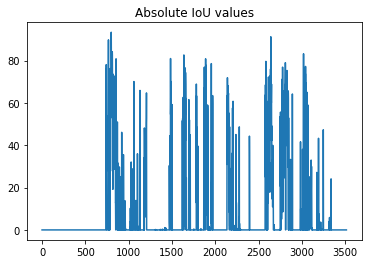

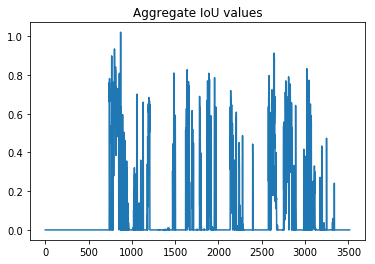

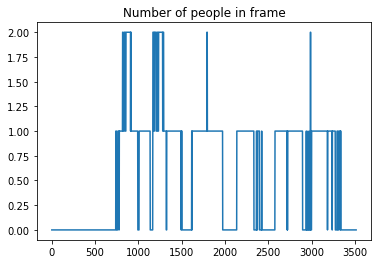

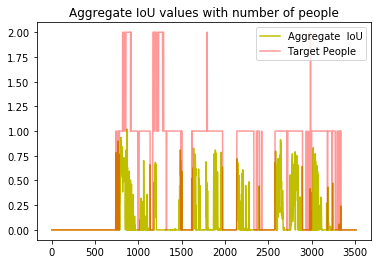

./test2/plots/absS abnd



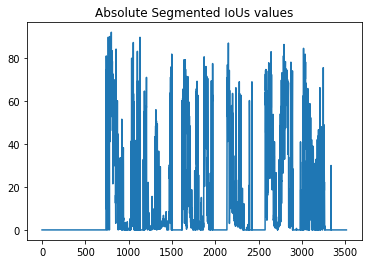

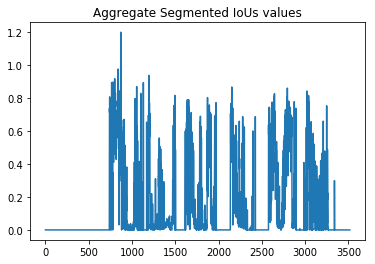

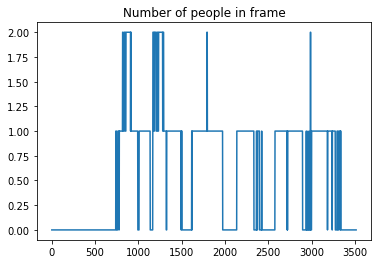

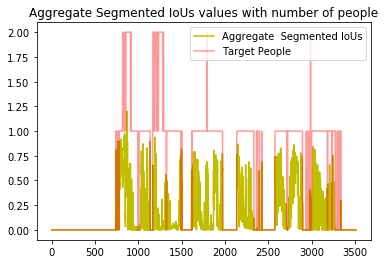

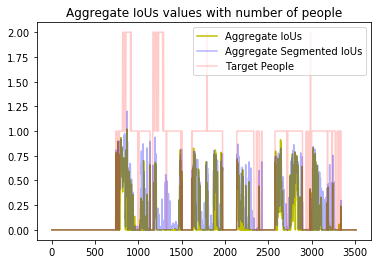

In [23]:
#plot general statistics and save the plots
plots_path = './test2/plots/'
save_figs = [True, True, False, True];
fig_names = [plots_path + 'abs', plots_path + 'aggr', 'as', plots_path + 'aggr_ppl' ];
fig_namesS = [plots_path + 'absS', plots_path + 'aggrS', 'as', plots_path + 'aggr_pplS' ];
label_IoU = 'IoUs'
label_segmented = 'Segmented IoUs'
plot_all(IoUs, save_figs = save_figs, fig_names = fig_names)
plot_all(segmented_IoUs, label_segmented, save_figs = save_figs, fig_names = fig_namesS)
plot_aggregate_with_people_diffs(IoUs, segmented_IoUs, save_fig = True, fig_name = plots_path + 'diffs')

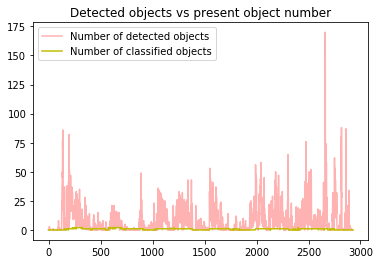

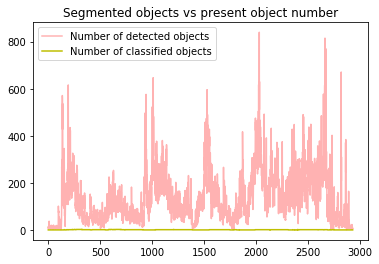

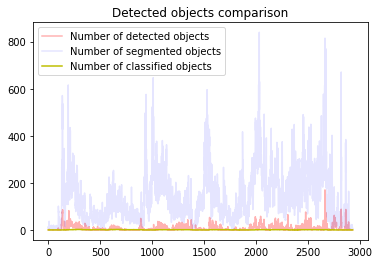

In [25]:
plot_nb_objects(nb_objects_test, nb_objects_classified, 'Detected objects vs present object number')
plot_nb_objects(nb_objects_test, nb_objects_segmented, 'Segmented objects vs present object number')
plot_nb_objects_diff(nb_objects_test, nb_objects_classified, nb_objects_segmented)

## Intersection over test box plotting

In [27]:
IoFs = compute_frames_IoU(labeled_test_boxes, labeled_classified_boxes, IoF)
segmented_IoFs = compute_frames_IoU(labeled_test_boxes, labeled_segmented_boxes, IoF)

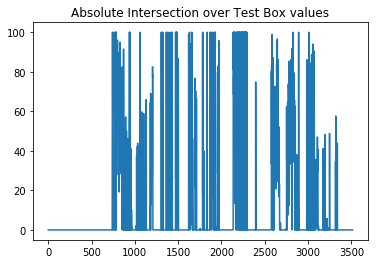

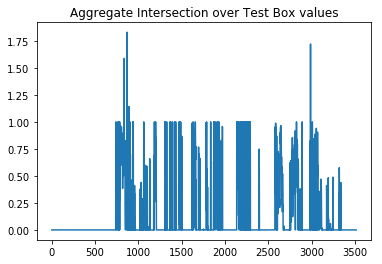

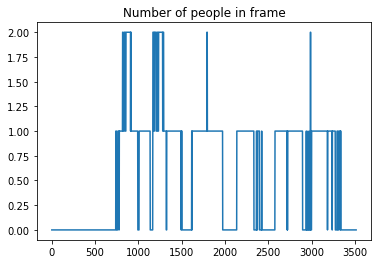

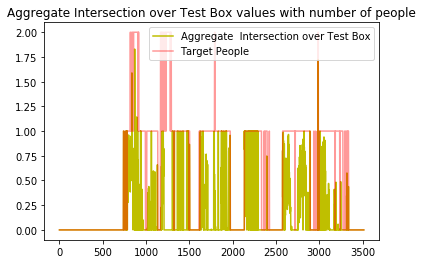

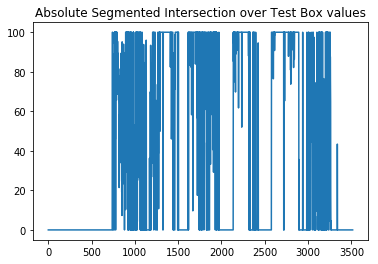

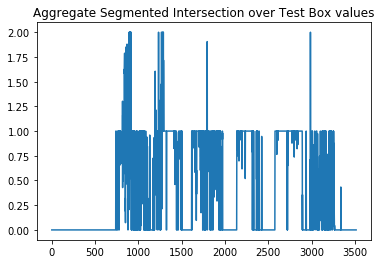

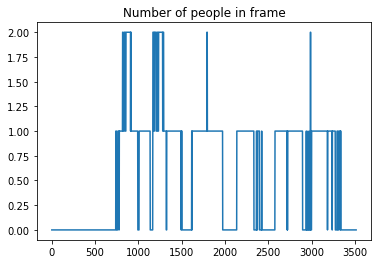

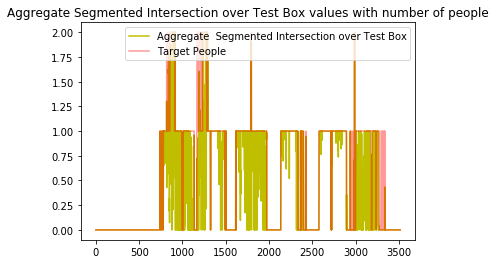

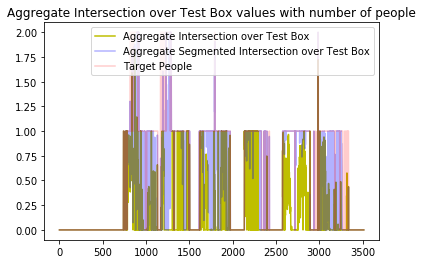

In [28]:
#plot general statistics
label_IoF = 'Intersection over Test Box'
label_segmented_IoF = 'Segmented Intersection over Test Box'
plot_all(IoFs, label_IoF)
plot_all(segmented_IoFs, label_segmented_IoF)
plot_aggregate_with_people_diffs(IoFs, segmented_IoFs, label_IoF, label_segmented_IoF)

## Comparison between IoU's and IoF's

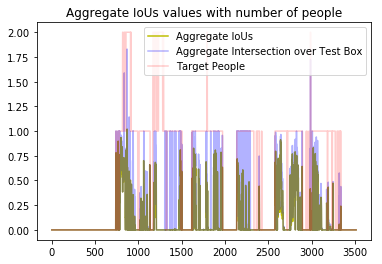

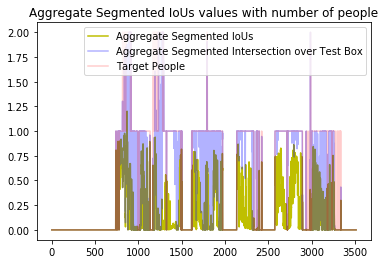

In [29]:
plot_aggregate_with_people_diffs(IoUs, IoFs, label_IoU, label_IoF)
plot_aggregate_with_people_diffs(segmented_IoUs, segmented_IoFs, label_segmented, label_segmented_IoF)

In [ ]:
IoUs

In [ ]:
plot_all(segmented_IoUs)

In [ ]:
# frames 801 - 844
# rocks classified as: beds (whole picture), cats(segmented)
# people classified as bird, kite, toothbrush, sports ball
# frame 1326 - classification actually looks like a teddy bear
# frame 1363 - backgroung roughly uniform ,looks like a bed

In [ ]:
# coordinates from annotations are centered?
# 640 on x, 480 on y seems decent, but not completely accurate
# 640 + x, 48 + y; center images before computin IoU

In [ ]:
img = read_image_bgr('./test2/dunseverick/frame00878.jpg')

In [ ]:


x = 320;
y = 240;
bbox = (2*x,3*y,3*x,4*y)
image = imcrop(img, bbox)

In [ ]:
process_cropped_image(image)

1.6666666666666667
processing time:  0.08261990547180176
1.6666666666666667
processing time:  0.07182931900024414
1.6666666666666667
processing time:  0.06719517707824707
1.6666666666666667
processing time:  0.06824421882629395
1.6666666666666667
processing time:  0.06899166107177734
1.6666666666666667
processing time:  0.06957864761352539
1.6666666666666667
processing time:  0.06650400161743164
1.6666666666666667
processing time:  0.06650614738464355
1.6666666666666667
processing time:  0.06785821914672852
1.6666666666666667
processing time:  0.07095932960510254
1.6666666666666667
processing time:  0.06953668594360352
1.6666666666666667
processing time:  0.06859850883483887
1.6666666666666667
processing time:  0.06866455078125
1.6666666666666667
processing time:  0.06637740135192871
1.6666666666666667
processing time:  0.06814241409301758
1.6666666666666667
processing time:  0.06592035293579102


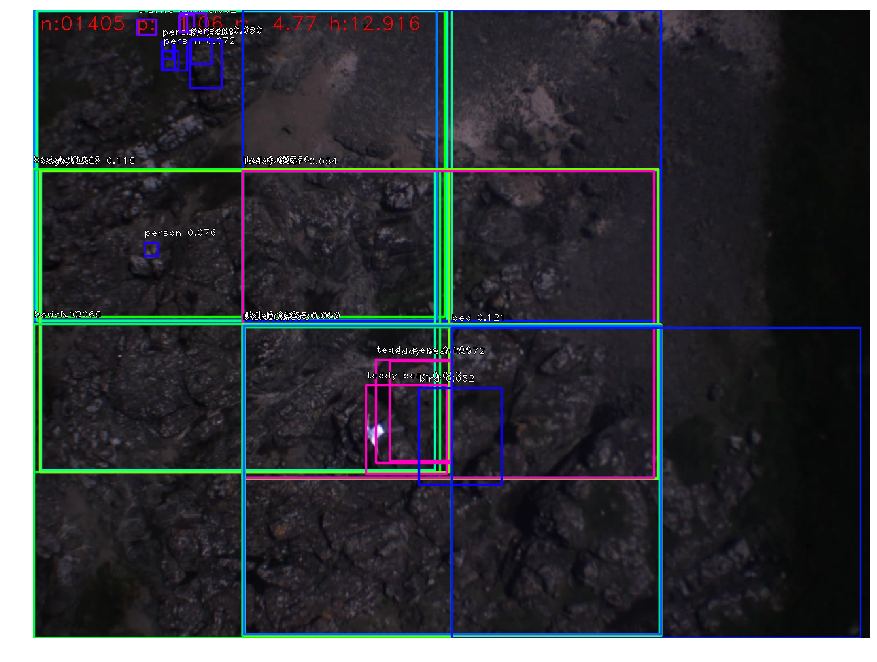

In [30]:
img_path = './test2/dunseverick/'
img_name = 'frame01405.jpg'
images = crop_image(img_path, img_name)
boxes = process_cropped_segments(img_path, img_name, True)

In [19]:
boxes

{'cat': [array([  2.0171814,   1.0920776, 633.908    , 476.14114  ], dtype=float32),
  array([ 12.166279, 246.27174 , 614.6575  , 703.22485 ], dtype=float32),
  array([321.3835 , 244.03116, 955.1255 , 715.783  ], dtype=float32),
  array([323.90192, 483.50183, 958.00714, 959.13824], dtype=float32)],
 'bed': [array([  0.    ,   0.    , 640.2   , 477.2976], dtype=float32),
  array([320.     ,   0.     , 960.2    , 475.36044], dtype=float32),
  array([  0.86142427, 243.55037   , 622.0313    , 706.87964   ],
        dtype=float32),
  array([320.     , 243.70377, 956.08997, 716.12317], dtype=float32),
  array([  1.0466194, 480.81238  , 640.09906  , 960.       ], dtype=float32),
  array([320.     , 484.81314, 960.2    , 960.     ], dtype=float32),
  array([ 640.     ,  485.78677, 1265.0042 ,  960.     ], dtype=float32)],
 'person': [array([196.79907 ,  49.339245, 216.69168 ,  91.57607 ], dtype=float32),
  array([197.0924 ,  48.86649, 213.01544,  74.72259], dtype=float32),
  array([197.20862 ,

In [ ]:
labeled_boxes = process_cropped_image(images[9])
bb = labeled_boxes['bird'][1]
print(bb)

In [ ]:
print(labeled_boxes)

In [ ]:
key = 'frame00881'
for obj, arr in labeled_boxes.items():
    for box in arr:
        #box += (640, 240, 640, 240)
        print(type(box))

print (labeled_boxes)

In [ ]:
abc_boxes = {}
abc_boxes[key] = labeled_boxes
res = compute_frame_IoU(key, labeled_test_boxes, abc_boxes)

In [ ]:
print(res)

In [ ]:
img_path = 'test1/images'
classified_path = 'test2/dunseverick_classified'
img_name = 'frame00788.jpg'
image_number = 1000
labeled_boxes = process_cropped_segments(img_path, img_name)
print(labeled_boxes)

In [ ]:
#TODO: CALL THIS AGAIN
#process all segmented images
img_path = 'test2/dunseverick'

img_name_prefix = 'frame'
first_image_number = 588
last_image_number = 3516
img_format = '.jpg'
labeled_boxes = process_cropped_images(img_path, img_name_prefix, first_image_number, last_image_number, img_format);
print(labeled_boxes)

In [ ]:
path_folder = './test2/segmented_annotations/'
img_name_prefix = 'frame'
first_image_number = 588
last_image_number = 3516

save_classifications_to_xml(labeled_boxes, path_folder, img_name_prefix, first_image_number, last_image_number)

In [ ]:
plot_all(segmented_IoUs)

In [ ]:
distance seems to explain some, but not all of the performance difference